In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import hamming_loss
import seaborn as sns

In [2]:
def scaleMatrix(matrix):
    return matrix.div(matrix.sum(axis=1),axis=0)

In [3]:
def norm(series):
    b = max(series)
    a = min(series)
    return [(x - a) / (b - a) for x in series]

In [4]:
def npmc(init_state, matrix, original_states, init_state_col):
    matrix = scaleMatrix(matrix)
    probs = {k:list(matrix.iloc[original_states.index(k)]) for k in original_states}
    NewState = []
    for x in range(len(init_state)):
        NewState.append(np.random.choice(a = matrix.columns, p = probs[init_state[init_state_col][x]],size=1)[0])
    NextStep = pd.DataFrame()
    NextStep["Original State"] = init_state[init_state_col]
    NextStep["New State"] = NewState
    return NextStep

In [5]:
def chain(init_state, matrix, original_states, init_state_col,n):
    init_state = init_state.copy()
    out = pd.DataFrame()
    out[0] = init_state[init_state_col]
    for i in range(1,n+1):
        out[i] = npmc(out,matrix,original_states,i-1)["New State"]
    return out

In [6]:
def proj(inp,X1,X2,n,start_state_col):
    sts = []
    inp.reset_index(drop = True,inplace = True)
    curr_st = inp[start_state_col].iloc[0]
    for step in range(n):
        sts.append(curr_st)
        if curr_st == -1:
            up_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            down_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[0] / n_neighbors
            curr_st = np.random.choice([0,1],1,p = [down_prob, up_prob])[0]
        else:
            up_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            down_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[0] / n_neighbors
            curr_st = np.random.choice([0,1],1,p = [down_prob, up_prob])[0]
    return sts

In [7]:
tick = pd.read_csv("NASDAQ_Ticks.csv")
all_data = {}
all_tm = {}
returns = {}
for x in tick["Ticker"]:
    
    df = pd.DataFrame()
    t0 = pd.read_csv(x+".csv")["Adj Close"]
    returns[x] = t0.pct_change().iloc[::3][1:]
    df["MMYYYY"] = [x[5:7] + x[:4] for x in pd.read_csv(x+".csv")["Date"][1:]]
    df.reset_index(drop = True,inplace = True)
    df["t0"] = np.where(t0.pct_change()[1:] > 0, 1, 0)
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace = True)
    
    df["t1"] = df["t0"].shift(-3)
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace = True)
    
    states = ["Up","Down"]
    TM = pd.DataFrame(index = ["Up","Down"])
    
    tm = {"UU":0,"UD":0,"DU":0,"DD":0}
    
    for i in range(2,len(df)):
        
        if df["t0"][i] == 1 and df["t0"][i-1] == 1:
            tm["UU"] += 1
        elif df["t0"][i] == 0 and df["t0"][i-1] == 1:
            tm["UD"] += 1
        elif df["t0"][i] == 1 and df["t0"][i-1] == 0:
            tm["DU"] += 1
        else:
            tm["DD"] += 1
            
    TM["Up"] = [tm["UU"],tm["UD"]]
    TM["Down"] = [tm["DU"],tm["DD"]]
    
    findf = pd.read_csv(x + "_quarterly_valuation_measures.csv",header=None).T
    findf.columns = findf.iloc[0]
    findf.drop([0,1],inplace=True)
    
    findf1 = pd.DataFrame()
    findf1["MMYYYY"] = [y[:2]+ y[6:10] for y in findf["name"].str.replace('/', '-')]
    try:
        findf1["PeRatio"] = np.log(findf["PeRatio"].str.replace(',', '').astype(float))
    except:
        findf1["PeRatio"] = np.log(findf["PegRatio"].str.replace(',', '').astype(float))
    findf1['MarketCap'] = np.log(findf['MarketCap'].str.replace(',', '').astype(float))
    findf1.interpolate(method='linear',inplace=True)
    
    findf1.dropna(inplace=True)
    findf1.reset_index(drop = True,inplace = True)
    
    alldf = df.merge(right=findf1, on = ["MMYYYY"])
    
    all_tm[x] = scaleMatrix(TM)
    all_data[x] = alldf

In [8]:
npdf = pd.DataFrame()
tk = []
my = []
t0 = []
t1 = []
ps = []
mc = []
for x in tick["Ticker"]:
    tk.extend([x for y in range(len(all_data[x]))])
    my.extend([x for x in all_data[x]["MMYYYY"]])
    t0.extend([x for x in all_data[x]["t0"]])
    t1.extend([x for x in all_data[x]["t1"]])
    ps.extend([x for x in all_data[x]["PeRatio"]])
    mc.extend([x for x in all_data[x]["MarketCap"]])
npdf["Ticker"] = tk
npdf["MMYYYY"] = my
npdf["t0"] = t0
npdf["t1"] = t1
npdf["PeRatio"] = ps
npdf["MarketCap"] = mc

In [9]:
np.random.seed(20)
test_comps = np.random.choice(tick["Ticker"],4, replace = False)

test = npdf.iloc[np.where(np.logical_or(np.logical_or(np.logical_or(
    npdf["Ticker"] == test_comps[0],
    npdf["Ticker"] == test_comps[1]),
    npdf["Ticker"] == test_comps[2]),
    npdf["Ticker"] == test_comps[3]))]
train = npdf.iloc[np.where(np.logical_and(np.logical_and(np.logical_and(
    npdf["Ticker"] != test_comps[0],
    npdf["Ticker"] != test_comps[1]),
    npdf["Ticker"] != test_comps[2]),
    npdf["Ticker"] != test_comps[3]))]
train.reset_index(drop = True,inplace = True)
test.reset_index(drop = True,inplace = True)
test_comps

array(['INCY', 'IDXX', 'ADI', 'KHC'], dtype=object)

In [10]:
npdfu = train.loc[npdf["t0"] == 1]

In [11]:
npdfd = train.loc[npdf["t0"] == 0]

In [12]:
n_neighbors = 8
scale = pd.DataFrame()
scale["MarketCap"] = norm(npdfu["MarketCap"])
scale["PeRatio"] = norm(npdfu["PeRatio"])
upknn = neighbors.KNeighborsClassifier(n_neighbors)
X = scale[["MarketCap","PeRatio"]]
y = npdfu["t1"]
upknn.fit(X,y)

KNeighborsClassifier(n_neighbors=8)

In [13]:
scale = pd.DataFrame()
scale["MarketCap"] = norm(npdfd["MarketCap"])
scale["PeRatio"] = norm(npdfd["PeRatio"])
downknn = neighbors.KNeighborsClassifier(n_neighbors)
X = scale[["MarketCap","PeRatio"]]
y = npdfd["t1"]
downknn.fit(X,y)

KNeighborsClassifier(n_neighbors=8)

In [14]:
p = 20

In [15]:
k = 0
PDCE = {}
pdce = test.loc[test["Ticker"] == test_comps[0]][["t0","t1","PeRatio","MarketCap"]]
pdce.reset_index(drop = True,inplace = True)
i=0
while p+k <= len(pdce):
    PDCE[i] = pdce.iloc[k:p+k]
    k+=p
    i+=1

In [16]:
k = 0
DQ = {}
dq = test.loc[test["Ticker"] == test_comps[1]][["t0","t1","PeRatio","MarketCap"]]
dq.reset_index(drop = True,inplace = True)
i=0
while p+k <= len(dq):
    DQ[i] = dq.iloc[k:p+k]
    k+=p
    i+=1

In [17]:
k = 0
PLUG = {}
plug = test.loc[test["Ticker"] == test_comps[2]][["t0","t1","PeRatio","MarketCap"]]
plug.reset_index(drop = True,inplace = True)
i=0
while p+k <= len(plug):
    PLUG[i] = plug.iloc[k:p+k]
    k+=p
    i+=1

In [18]:
k = 0
VLO = {}
vlo = test.loc[test["Ticker"] == test_comps[3]][["t0","t1","PeRatio","MarketCap"]]
vlo.reset_index(drop = True,inplace = True)
i=0
while p+k <= len(vlo):
    VLO[i] = vlo.iloc[k:p+k]
    k+=1
    i+=1

In [19]:
len(PDCE),len(DQ),len(PLUG),len(VLO)

(5, 5, 7, 3)

In [20]:
np.random.seed(10)
testloss = []
n = 100
for j in range(len(PDCE)):
    for i in range(n):
        out = proj(PDCE[j],"PeRatio","MarketCap",len(PDCE[j]),"t0")
        testloss.append(hamming_loss(out[1:],PDCE[j]["t1"][1:]))
for j in range(len(DQ)):
    for i in range(n):
        out = proj(DQ[j],"PeRatio","MarketCap",len(DQ[j]),"t0")
        testloss.append(hamming_loss(out[1:],DQ[j]["t1"][1:]))
for j in range(len(PLUG)):
    for i in range(n):
        out = proj(PLUG[j],"PeRatio","MarketCap",len(PLUG[j]),"t0")
        testloss.append(hamming_loss(out[1:],PLUG[j]["t1"][1:]))
for j in range(len(VLO)):
    for i in range(n):
        out = proj(VLO[j],"PeRatio","MarketCap",len(VLO[j]),"t0")
        testloss.append(hamming_loss(out[1:],VLO[j]["t1"][1:]))

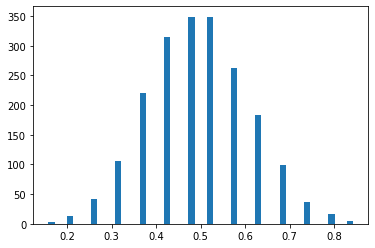

count    2000.000000
mean        0.495158
std         0.113541
min         0.157895
10%         0.368421
20%         0.421053
30%         0.421053
40%         0.473684
50%         0.473684
60%         0.526316
70%         0.578947
80%         0.578947
90%         0.631579
max         0.842105
dtype: float64

In [21]:
plt.hist(testloss, bins = 50)
plt.show()
testloss = pd.Series(testloss)
testloss.describe(percentiles = [0.1+0.1*i for i in range(9)])

In [22]:
TM = pd.DataFrame(index = [1,0])

tm = {"UU":0,"UD":0,"DU":0,"DD":0}

for x in tick["Ticker"]:
    if x not in test_comps:
        tm["UU"] += all_tm[x]["Up"]["Up"]
        tm["DU"] += all_tm[x]["Down"]["Up"]
        tm["UD"] += all_tm[x]["Up"]["Down"]
        tm["DD"] += all_tm[x]["Down"]["Down"]
TM[1] = [tm["UU"],tm["UD"]]
TM[0] = [tm["DU"],tm["DD"]]
TM = scaleMatrix(TM)

In [23]:
np.random.seed(10)
ptspdce = {}
for i in range(len(PDCE)):
    ptspdce[i] = pd.DataFrame()
    ptspdce[i]["t0"] = [PDCE[i]["t0"][0]]
    
ptsdq = {}
for i in range(len(DQ)):
    ptsdq[i] = pd.DataFrame()
    ptsdq[i]["t0"] = [DQ[i]["t0"][0]]
    
ptsplug = {}
for i in range(len(PLUG)):
    ptsplug[i] = pd.DataFrame()
    ptsplug[i]["t0"] = [PLUG[i]["t0"][0]]

ptsvlo = {}
for i in range(len(VLO)):
    ptsvlo[i] = pd.DataFrame()
    ptsvlo[i]["t0"] = [VLO[i]["t0"][0]]

ptsloss = []
for j in range(len(PDCE)):
    for i in range(n):
        out = chain(init_state = ptspdce[j], matrix = TM, original_states = [1,0], init_state_col = "t0",n=len(PDCE[j])-1)
        ptsloss.append(hamming_loss(out.iloc[0][1:],PDCE[j]["t1"][1:]))
for j in range(len(DQ)):
    for i in range(n):
        out = chain(init_state = ptsdq[j], matrix = TM, original_states = [1,0], init_state_col = "t0",n=len(DQ[j])-1)
        ptsloss.append(hamming_loss(out.iloc[0][1:],DQ[j]["t1"][1:]))
for j in range(len(PLUG)):
    for i in range(n):
        out = chain(init_state = ptsplug[j], matrix = TM, original_states = [1,0], init_state_col = "t0",n=len(PLUG[j])-1)
        ptsloss.append(hamming_loss(out.iloc[0][1:],PLUG[j]["t1"][1:]))
for j in range(len(VLO)):
    for i in range(n):
        out = chain(init_state = ptsvlo[j], matrix = TM, original_states = [1,0], init_state_col = "t0",n=len(VLO[j])-1)
        ptsloss.append(hamming_loss(out.iloc[0][1:],VLO[j]["t1"][1:]))

In [24]:
len(ptspdce),len(ptsdq),len(ptsplug),len(ptsvlo)

(5, 5, 7, 3)

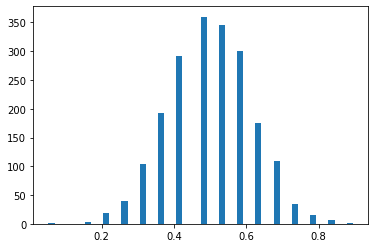

count    2000.000000
mean        0.499026
std         0.114865
min         0.052632
10%         0.368421
20%         0.421053
30%         0.421053
40%         0.473684
50%         0.473684
60%         0.526316
70%         0.578947
80%         0.578947
90%         0.631579
max         0.894737
dtype: float64

In [25]:
plt.hist(ptsloss, bins = 50)
plt.show()
ptsloss = pd.Series(ptsloss)
ptsloss.describe(percentiles = [0.1+0.1*i for i in range(9)])

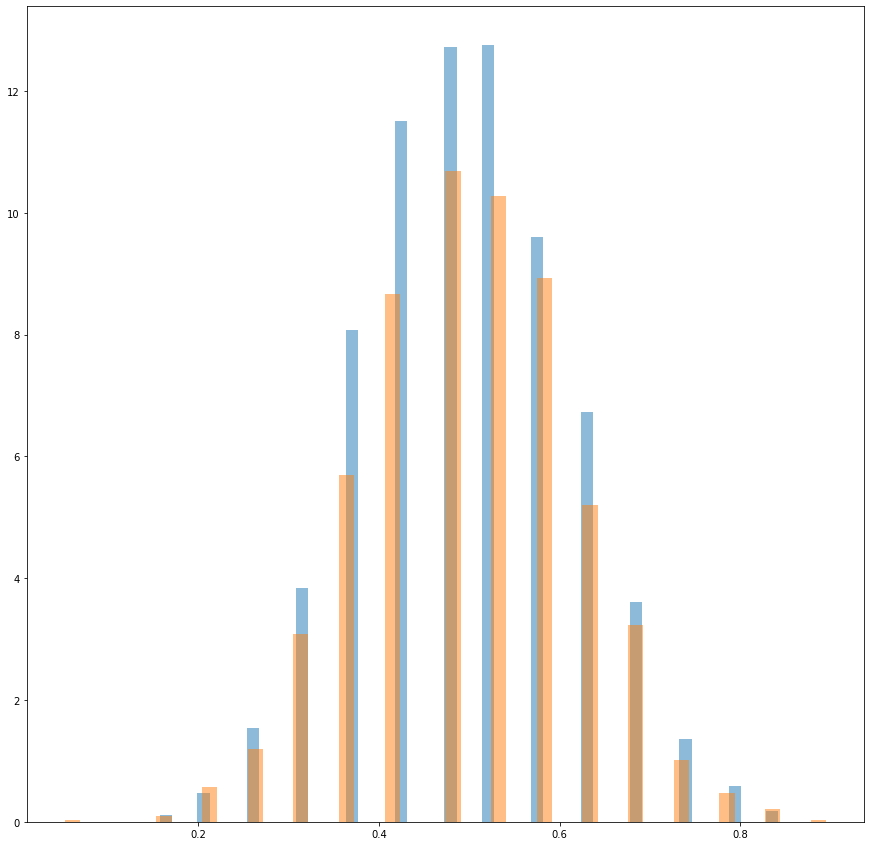

In [26]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.hist(testloss, bins = 50, alpha = 0.5,density=True)
plt.hist(ptsloss, bins = 50,alpha = 0.5,density=True)
plt.show()

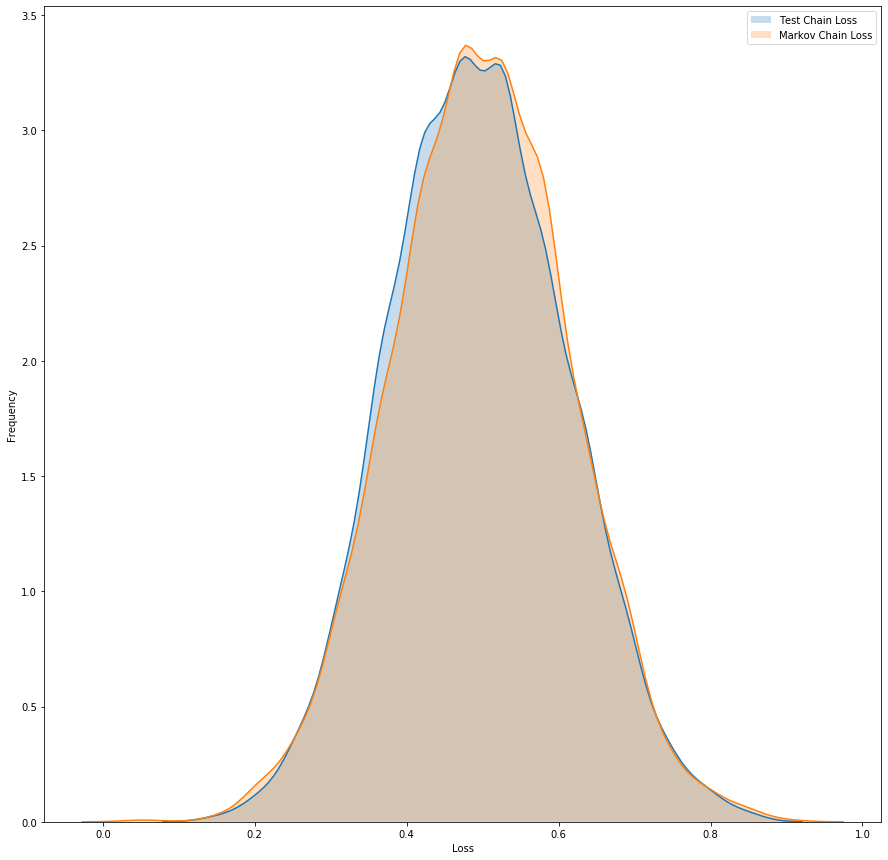

In [27]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
sns.kdeplot(testloss,shade=True)
sns.kdeplot(ptsloss,shade=True)
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend(["Test Chain Loss","Markov Chain Loss"])
plt.show()